In [2]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot convergence for IMEX-RB on 2D nonlinear problem
We study convergence on the 2D viscous Burgers equation

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = "Burgers2D"
test_name = "convergence"
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')


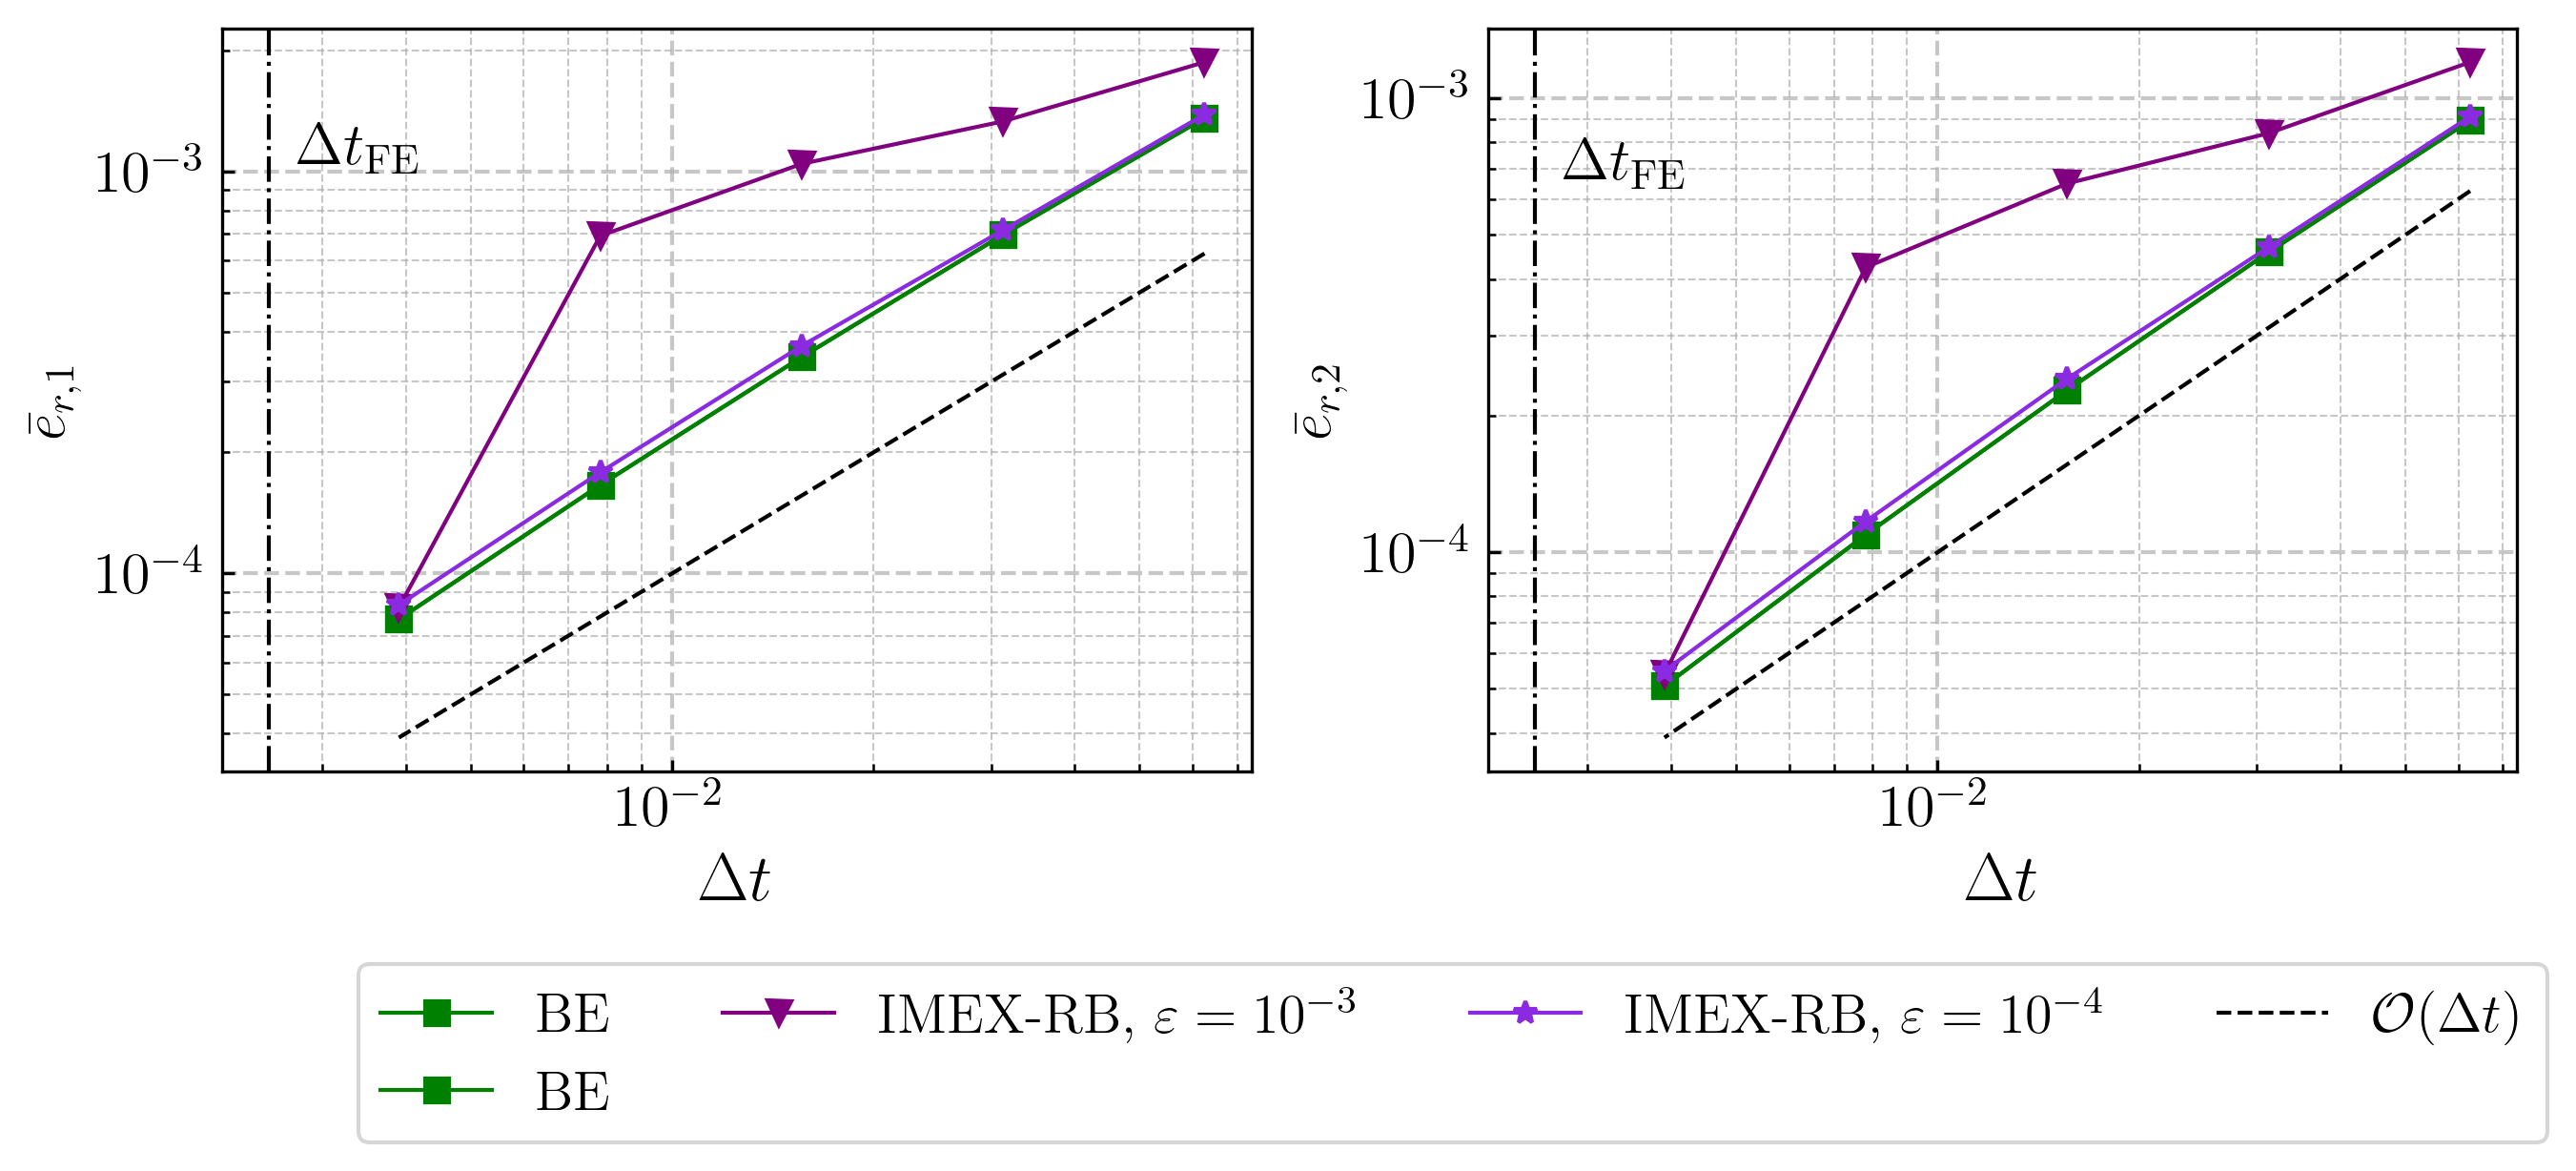

In [7]:
plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_l2 = data['errors_l2'].item()
Nt_values = data['Nt_values']                
epsilon_values = data['epsilon_values']
NtFE = 400  # Hard‐coded FE Nt for reference

# Compute the dt array from Nt_values:
dts = 1.0 / Nt_values

# Markers and colors for IMEX‐RB:
all_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
all_colors = ['purple', 'blueviolet', 'magenta', 'hotpink',
              'red', 'maroon', 'teal', 'orange']

# We will plot two components (comp = 0 and comp = 1)
methods = ['BE', 'IMEX-RB']

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

for comp in range(errors_l2['BE'].shape[0]):
    ax = axes[comp]

    errs_be = errors_l2['BE'][comp]
    ax.loglog(
        dts,
        errs_be,
        marker='s',
        markersize=6,
        color='green',
        linestyle='-',
        label='BE'
    )

    for ie, eps in enumerate(epsilon_values):

        errs_imex = errors_l2['IMEX-RB'][comp, :, ie]
        expnt = int(np.log10(eps))
        label_imex = rf'IMEX-RB, $\varepsilon = 10^{{{expnt}}}$'

        ax.loglog(
            dts,
            errs_imex,
            marker=all_markers[ie],
            markersize=6,
            color=all_colors[ie],
            linestyle='-',
            label=label_imex
        )

    ax.loglog(
        dts,
        [dt / 100.0 for dt in dts],
        label=r"$\mathcal{O}(\Delta t)$",
        color="k",
        linestyle='--'
    )

    ax.axvline(1 / NtFE, color="k", linestyle='-.')
    ax.text(
        1 / NtFE * 1.1,
        ax.get_ylim()[1] * 0.5,
        rf'$\Delta t_{{\mathrm{{FE}}}}$',
        rotation=0,
        verticalalignment='center',
        color='k',
        fontsize=15
    )

    ax.grid(which='major', linestyle='--', linewidth=1)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)

    ax.set_xlabel(r'$\Delta t$', fontsize=17)
    ax.set_ylabel(rf'$\bar{{e}}_{{r,{comp+1}}}$', fontsize=15)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.57, 0.05),
    loc='upper center',
    ncol=4,      
    fontsize=14
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
out_file = os.path.join(plots_dir, f'{problem_name}_convergence_combined.pdf')
plt.savefig(out_file, bbox_inches='tight', dpi=400)
plt.show()
plt.close()
